**Importeren biblotheken**

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
#! pip install -r /Users/PJT/Desktop/DEX_presentatie/requirements.txt

**1. Data inladen**
* van Opendata een .csv-bestand met alle data gedownload van zowel benzine als gas

In [10]:
benzine_file = "C:/Users/PJT/Desktop/DEX_presentatie/DEX_2025_kopie/fuel/3Benzine.csv"
gas_file = "C:/Users/PJT/Desktop/DEX_presentatie/DEX_2025_kopie/fuel/3Gas.csv"

**2. Data opschonen/voorbereiden**
* maken van de csv een dataframe (tabel)

In [11]:
df_benzine = pd.read_csv(benzine_file, delimiter=";", quotechar='"')
df_gas = pd.read_csv(gas_file, delimiter=";", quotechar='"')

df_benzine.columns = ["ID", "Datum", "Benzineprijs"]
df_gas.columns = ["ID", "Datum", "Gasprijs"]

df_benzine["Datum"] = pd.to_datetime(df_benzine["Datum"], format="%Y%m%d")
df_gas["Datum"] = pd.to_datetime(df_gas["Datum"], format="%Y%m%d")

df_benzine.drop(columns=["ID"], inplace=True)
df_gas.drop(columns=["ID"], inplace=True)

# Convert prijzen naar floats
df_benzine["Benzineprijs"] = df_benzine["Benzineprijs"].astype(str).str.strip().str.replace(",", ".").astype(float)
df_gas["Gasprijs"] = df_gas["Gasprijs"].astype(str).str.strip().str.replace(",", ".").astype(float)

# Merge datasets op datum
df = pd.merge(df_benzine, df_gas, on="Datum", how="inner")

print(df.head())
print("---------------------------------------------------------------")
print(df.describe())

       Datum  Benzineprijs  Gasprijs
0 2006-01-01         1.325     0.543
1 2006-01-02         1.328     0.542
2 2006-01-03         1.332     0.540
3 2006-01-04         1.348     0.550
4 2006-01-05         1.347     0.550
---------------------------------------------------------------
                               Datum  Benzineprijs     Gasprijs
count                           6988   6988.000000  6988.000000
mean   2015-07-26 12:00:00.000000256      1.641174     0.675434
min              2006-01-01 00:00:00      1.151000     0.435000
25%              2010-10-13 18:00:00      1.493000     0.588000
50%              2015-07-26 12:00:00      1.622000     0.667000
75%              2020-05-07 06:00:00      1.754000     0.752000
max              2025-02-17 00:00:00      2.383000     1.174000
std                              NaN      0.211144     0.118839


**3. Visualisatie van benzine- en gasprijzen totale dataset**

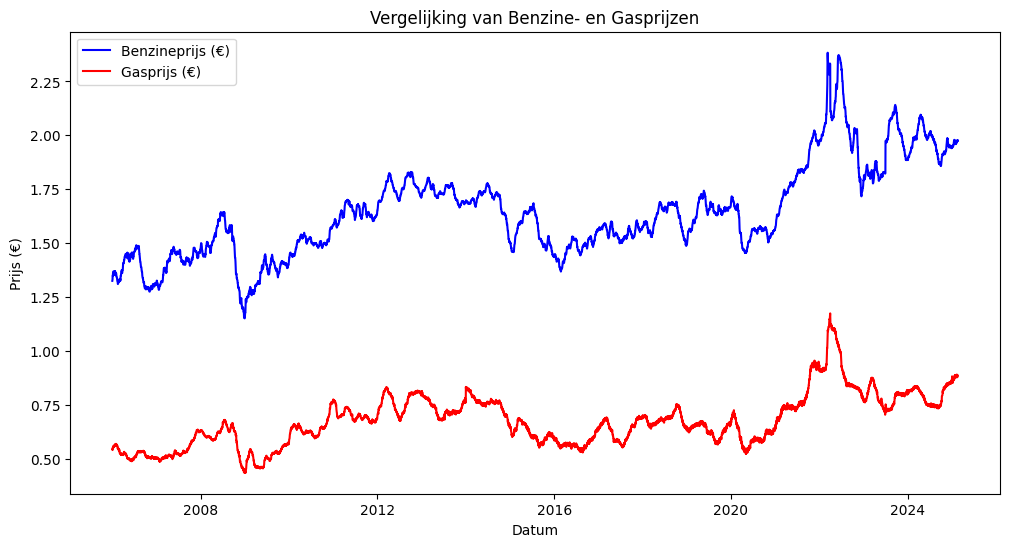

In [12]:
plt.figure(figsize=(12,6))
plt.plot(df["Datum"], df["Benzineprijs"], label="Benzineprijs (€)", color="blue")
plt.plot(df["Datum"], df["Gasprijs"], label="Gasprijs (€)", color="red")
plt.xlabel("Datum")
plt.ylabel("Prijs (€)")
plt.title("Vergelijking van Benzine- en Gasprijzen")
plt.legend()
plt.show()

**4. Train/test split - Verwijder 2021-2025 voor voorspellingen**

In [13]:
df_train = df[df["Datum"] < "2021-01-01"]
df_test = df[df["Datum"] >= "2021-01-01"]

**4. LSTM-model trainen en voorspellen (het algoritme)**

mini neuraal netwerk (Long Short-Term Memory) = goed in voorspellen van patronen in data die in de tijd veranderen

* Invoegen data
* Model bouwen
* Model trainen

In [14]:
# plaatje van lagen + uitleg vaN LAGEN VOOR NOOB + HERINNEREN WAT LAGEN DOEN IN dl

In [15]:
window_size = 730 # aantal dagen dat het model data gaat gebruiken= tijdstappen

def create_sequences(data, window_size):
    sequences, labels = [], []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i+window_size])
        labels.append(data[i+window_size])
    return np.array(sequences), np.array(labels)

# Voeg inputdata voor model toe door omzetten naar numpy array
price_series_benzine = df_train["Benzineprijs"].values.reshape(-1, 1)
X_benzine, y_benzine = create_sequences(price_series_benzine, window_size)

price_series_gas = df_train["Gasprijs"].values.reshape(-1, 1)
X_gas, y_gas = create_sequences(price_series_gas, window_size)

# Bouw LSTM-model
def build_lstm_model():
    model = Sequential([
        #laag 1:
        LSTM(50, return_sequences=True, input_shape=(window_size, 1)),
        Dropout(0.2),
        #laag 2:
        LSTM(50, return_sequences=False),
        Dropout(0.2), 
        #laag 3:
        Dense(25, activation="relu"),
        #laag 4:
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

# EarlyStopping om training te stoppen als de loss niet meer verbetert
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train modellen met EarlyStopping en Dropout
model_lstm_benzine = build_lstm_model()
history_benzine = model_lstm_benzine.fit(
    X_benzine, y_benzine, 
    epochs=10, batch_size=32, verbose=1, validation_split=0.1,
    callbacks=[early_stopping]
)

model_lstm_gas = build_lstm_model()
history_gas = model_lstm_gas.fit(
    X_gas, y_gas, 
    epochs=10, batch_size=32, verbose=1, validation_split=0.1,
    callbacks=[early_stopping]
)

Epoch 1/10
134/134 [==============================] - 171s 1s/step - loss: 0.1832 - val_loss: 0.0042
Epoch 2/10
134/134 [==============================] - 175s 1s/step - loss: 0.0225 - val_loss: 0.0019
Epoch 3/10
134/134 [==============================] - 184s 1s/step - loss: 0.0149 - val_loss: 0.0062
Epoch 4/10
134/134 [==============================] - 182s 1s/step - loss: 0.0121 - val_loss: 0.0060
Epoch 1/10
134/134 [==============================] - 170s 1s/step - loss: 0.0203 - val_loss: 4.5374e-04
Epoch 2/10
134/134 [==============================] - 169s 1s/step - loss: 0.0030 - val_loss: 3.9246e-04
Epoch 3/10
134/134 [==============================] - 176s 1s/step - loss: 0.0020 - val_loss: 6.0703e-04
Epoch 4/10
134/134 [==============================] - 183s 1s/step - loss: 0.0015 - val_loss: 0.0017


In [16]:
# 134 ??
datapunten = 6988 - 730 = 6258 
730 dagen te voorspellen: 730 x 6258 = 4.569.340
batches = 32 (6258/32) = 196

1 epoch verwerkt 196 keer een batch van 32 samples
10 keer = 1960 batches

SyntaxError: cannot assign to expression (97102123.py, line 1)

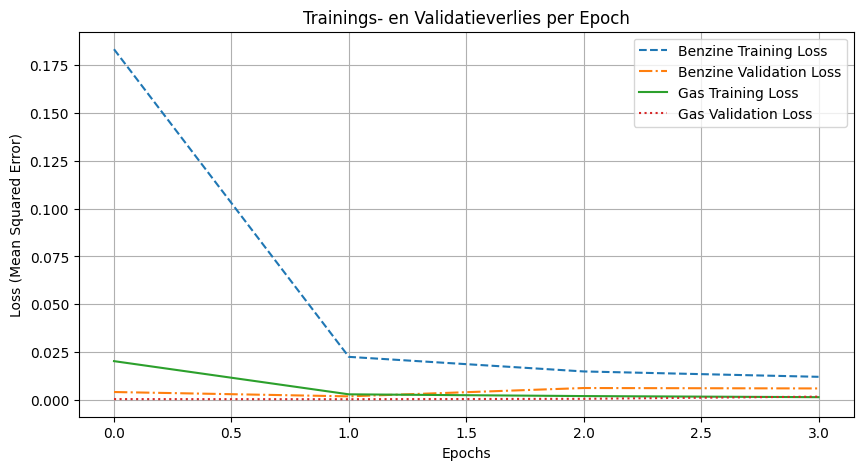

In [17]:
# Plot trainingsverlies per epoch
plt.figure(figsize=(10,5))
plt.plot(history_benzine.history['loss'], label="Benzine Training Loss", linestyle='--')
plt.plot(history_benzine.history['val_loss'], label="Benzine Validation Loss", linestyle='-.')
plt.plot(history_gas.history['loss'], label="Gas Training Loss", linestyle='-')
plt.plot(history_gas.history['val_loss'], label="Gas Validation Loss", linestyle=':')
plt.xlabel("Epochs")
plt.ylabel("Loss (Mean Squared Error)")
plt.title("Trainings- en Validatieverlies per Epoch")
plt.legend()
plt.grid(True)
plt.show()

**5. Voorspellingen genereren voor 2021-2025**

In [18]:
future_months = 12 * 5  # 5 jaar vooruit = 60 maanden
future_steps = future_months

future_steps = future_months
tf.get_logger().setLevel('ERROR')

def predict_future(model, last_window, steps):
    predictions = []
    current_window = last_window.copy()
    
    for _ in range(steps):
        with tf.device('/CPU:0'):
            prediction = model.predict(current_window.reshape(1, window_size, 1), verbose=0)[0][0]
        
        predictions.append(prediction)
        current_window = np.append(current_window[1:], prediction).reshape(window_size, 1)
    
    return np.array(predictions)

last_window_benzine = price_series_benzine[-window_size:]
last_window_gas = price_series_gas[-window_size:]

future_benzine = predict_future(model_lstm_benzine, last_window_benzine, future_steps)
future_gas = predict_future(model_lstm_gas, last_window_gas, future_steps)

**6. Voorspellingen opslaan en visualiseren**

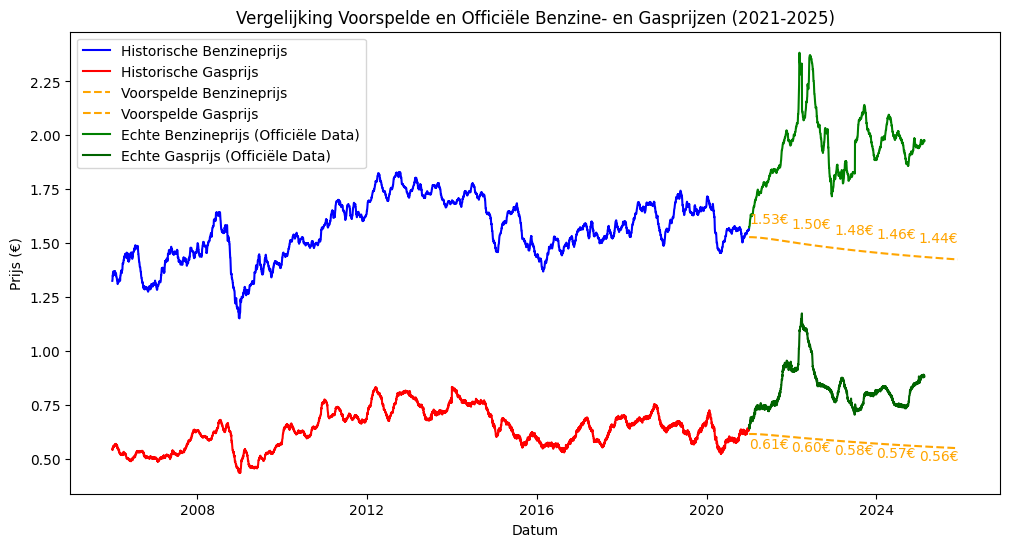

In [19]:
start_date = pd.to_datetime("2021-01-01")
future_dates = pd.date_range(start=start_date, periods=future_steps, freq='MS')

future_df = pd.DataFrame({
    "Datum": future_dates,
    "Voorspelde Benzineprijs (€)": future_benzine,
    "Voorspelde Gasprijs (€)": future_gas
})
future_df.set_index("Datum", inplace=True)

plt.figure(figsize=(12,6))

plt.plot(df_train["Datum"], df_train["Benzineprijs"], label="Historische Benzineprijs", color="blue")
plt.plot(df_train["Datum"], df_train["Gasprijs"], label="Historische Gasprijs", color="red")

plt.plot(future_df.index, future_df["Voorspelde Benzineprijs (€)"], label="Voorspelde Benzineprijs", color="orange", linestyle="dashed")
plt.plot(future_df.index, future_df["Voorspelde Gasprijs (€)"], label="Voorspelde Gasprijs", color="orange", linestyle="dashed")

plt.plot(df_test["Datum"], df_test["Benzineprijs"], label="Echte Benzineprijs (Officiële Data)", color="green", linestyle="solid")
plt.plot(df_test["Datum"], df_test["Gasprijs"], label="Echte Gasprijs (Officiële Data)", color="darkgreen", linestyle="solid")

for year in range(2021, 2026):
    if year in future_df.index.year:
        year_data = future_df.loc[future_df.index.year == year]
        first_entry = year_data.iloc[0]  # Eerste waarde van dat jaar
        
        # Benzineprijs-label met extra padding omhoog
        plt.text(first_entry.name, first_entry["Voorspelde Benzineprijs (€)"] + 0.05, 
                 f"{first_entry['Voorspelde Benzineprijs (€)']:.2f}€", 
                 verticalalignment='bottom', color="orange", fontsize=10)
        
        # Gasprijs-label met extra padding omhoog
        plt.text(first_entry.name, first_entry["Voorspelde Gasprijs (€)"] - 0.08, 
                 f"{first_entry['Voorspelde Gasprijs (€)']:.2f}€", 
                 verticalalignment='bottom', color="orange", fontsize=10)

plt.xlabel("Datum")
plt.ylabel("Prijs (€)")
plt.title("Vergelijking Voorspelde en Officiële Benzine- en Gasprijzen (2021-2025)")
plt.legend()
plt.show()
